# Entrenamiento
____________
## Importaciones

In [1]:
import os
os.chdir('..') # Modifico a una carpeta hacia atras
os.listdir() # Compruebo viendo que estan las carpetas dentro de src

['catboost_info',
 'data',
 'memoria.ipynb',
 'modelo_best.pkl',
 'modelo_smote.pkl',
 'modelo_smoteenn_xgb.pkl',
 'modelo_smote_xgb.pkl',
 'modelo_under.pkl',
 'modelo_wouimb.pkl',
 'notebooks',
 'utils']

In [2]:
# Importacion de utils
from utils.funcions import *
from utils.modulos import *
import utils.toolbox_ML as tb
import utils.bootcampviztools as bt

## Carga de datos mapeados, procesados y sets de entrenamiento, validacion y test

In [3]:
print("Ruta actual:", os.getcwd())
os.listdir()
os.chdir('src')
os.listdir()

Ruta actual: c:\Users\sorim\BOOTCAMP_EJERCICIOS\Proyectos\ML_final


['catboost_info',
 'data',
 'memoria.ipynb',
 'modelo_best.pkl',
 'modelo_smote.pkl',
 'modelo_smoteenn_xgb.pkl',
 'modelo_smote_xgb.pkl',
 'modelo_under.pkl',
 'modelo_wouimb.pkl',
 'notebooks',
 'utils']

In [4]:
df_map = pd.read_csv('./data/processed/dataset_mapeado.csv')
X_train_processed = pd.read_csv('./data/processed/X_train_preprocessing.csv')

train_set = pd.read_csv('./data/processed/train_set.csv')
val_set = pd.read_csv('./data/processed/val_set.csv')
test_set = pd.read_csv('./data/processed/test_set.csv')

In [5]:
# Instancio el target, las variables numéricas y categóricas
target = 'Target'
var_num = [col for col in df_map.select_dtypes(include=['number']).columns if df_map[col].nunique() > 2]
var_cat = [col for col in df_map.columns if col not in var_num and col != target]

In [6]:
# Creacion de las parejas X,y
X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_val = val_set.drop(target, axis=1)
y_val = val_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

In [7]:
y_train.value_counts(True)

Target
Graduate    0.505370
Dropout     0.313454
Enrolled    0.181176
Name: proportion, dtype: float64

In [8]:
# Transformo las clases a numérica
mapping = {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}

y_train_num = y_train.replace(mapping)
y_val_num = y_val.replace(mapping)
y_test_num = y_test.replace(mapping)


In [9]:
y_train_num.value_counts(True)

Target
0    0.505370
1    0.313454
2    0.181176
Name: proportion, dtype: float64

In [10]:
# Instancio las variables donde quiero aplicar cada transformacion
one_cat = ['Marital status', 'Application mode', 'Course', 'Nacionality', 'Gender', "Mother's occupation", "Father's occupation"]
order_cat = ['Previous qualification', "Mother's qualification", "Father's qualification"]

In [11]:
# Instancio las variables según los análisis realizados anteriormente
features_visual = ['Displaced', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Application mode', 'Course', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Age at enrollment', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (approved)', 'Inflation rate', 'GDP']
features_test = ['Application mode', "Mother's occupation", 'Debtor', 'Tuition fees up to date','Scholarship holder', 'Application order', 'Age at enrollment', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)']
features_rfe = ['Age at enrollment', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (evaluations)','Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'GDP']
pca_components = 41
features_hard = ['Debtor','Tuition fees up to date','Scholarship holder', 'Application mode', "Mother's occupation", 'Age at enrollment', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (evaluations)','Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (approved)','GDP']
features_all = train_set.columns.drop(target).to_list()

## Carga de Pipelines

In [12]:
# Variables especificando el orden de cada categoría
categorias_student = [['Basic education 2nd cycle (6th/7th/8th year) or equivalent', 'Basic education 3rd cycle (9th/10th/11th year) or equivalent', '10th year of schooling—not completed', '10th year of schooling',\
                      '11th year of schooling—not completed', 'Other—11th year of schooling', '12th year of schooling—not completed', 'Secondary education', 'Technological specialization course', 'Professional higher technical course',\
                        'Frequency of higher education', 'Higher education—degree (1st cycle)', 'Higher education—bachelor’s degree', 'Higher education—degree', 'Higher education—master’s degree (2nd cycle)',\
                            'Higher education—master’s degree', 'Higher education—doctorate']]
categorias_father = [['Cannot read or write', 'Can read without having a 4th year of schooling', 'Basic education 1st cycle (4th/5th year) or equivalent', 'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent', '7th year of schooling', '7th Year (Old)', '8th year of schooling',\
                     '9th Year of Schooling—not completed', '10th Year of Schooling', 'Other—11th Year of Schooling', '11th Year of Schooling—not completed', '12th Year of Schooling—not completed', 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent',\
                     'Secondary Education—12th Year of Schooling or Equivalent', 'General Course of Administration and Commerce', '2nd year complementary high school course', 'Complementary High School Course',\
                        'Complementary High School Course—not concluded', '2nd cycle of the general high school course', 'Frequency of Higher Education', 'Higher education—degree (1st cycle)', 'Technological specialization course',\
                            'Technical-professional course', 'Professional higher technical course', 'Higher Education—bachelor’s degree', 'Higher Education—degree', 'Specialized higher studies course', 'Higher Education—master’s degree (2nd cycle)',\
                                'Higher Education—master’s degree', 'Higher Education—doctorate (3rd cycle)', 'Higher Education—doctorate', 'Supplementary Accounting and Administration', 'Unknown']]
categorias_mother = [['Cannot read or write', 'Can read without having a 4th year of schooling', 'Basic education 1st cycle (4th/5th year) or equivalent', 'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent', '7th year of schooling', '7th Year (Old)', '8th year of schooling',\
                     '9th Year of Schooling—not completed', 'Other—11th Year of Schooling', '11th Year of Schooling—not completed', '12th Year of Schooling—not completed', 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent',\
                     'Secondary Education—12th Year of Schooling or Equivalent', 'General commerce course', 'General Course of Administration and Commerce', '2nd year complementary high school course', 'Complementary High School Course',\
                        'Complementary High School Course—not concluded', '2nd cycle of the general high school course', 'Frequency of Higher Education', 'Technical-professional course', 'Higher Education—bachelor’s degree', 'Higher Education—degree',\
                                'Higher Education—master’s degree', 'Higher Education—doctorate', 'Supplementary Accounting and Administration', 'Unknown']]

Me estaba dando error continuamente porque, en un principio, cree un preprocesado con todas las columnas, para después, en el CV, especificar la selección de features. Yo pensaba que si no estaban las columnas en el preprocesado, no realizaba ninguna acción y no las añadía al DF preprocesado. Después de muchas horas, me di cuenta qué es lo que ocurría y realicé la siguiente estrategia.

Especifico los tipos de transformaciones que hay en cada selección de features para crear un pipeline por cada selección.

In [13]:
# Especifico los tipos de tranformaciones que tiene 'features_visual'
num_visual = [col for col in var_num if col in features_visual]
one_visual = [col for col in one_cat if col in features_visual]
order_visual = [col for col in order_cat if col in features_visual]

In [14]:
order_visual

["Mother's qualification", "Father's qualification"]

In [15]:
# Especifico los tipos de tranformaciones que tiene 'features_test'
num_test = [col for col in var_num if col in features_test]
one_test = [col for col in one_cat if col in features_test]

In [16]:
# Especifico los tipos de tranformaciones que tiene 'features_rfe'
num_rfe = [col for col in var_num if col in features_rfe]

In [17]:
# Especifico los tipos de tranformaciones que tiene 'features_hard'
num_hard = [col for col in var_num if col in features_hard]
one_hard = [col for col in one_cat if col in features_hard]

In [18]:
# Pipeline numerico
pipe_num = Pipeline(
    [('log', FunctionTransformer(log_transform, validate=False, feature_names_out='one-to-one')),
     ('SScaler', StandardScaler())]
)

In [19]:
# Pipeline especificos por cada seleccion de features
preprocessing_visual = ColumnTransformer([
    ('Impute_numeric', pipe_num, num_visual),
    ('One-hot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), one_visual),
    ('Ordinal-father', OrdinalEncoder(categories=categorias_father, handle_unknown='use_encoded_value', unknown_value=-1), ["Father's qualification"]), # asigno valores a categorias que pueden estar en el set de test y no en el de train
    ('Ordinal-mother', OrdinalEncoder(categories=categorias_mother, handle_unknown='use_encoded_value', unknown_value=-1), ["Mother's qualification"])
], remainder='passthrough')

preprocessing_test = ColumnTransformer([
    ('Impute_numeric', pipe_num, num_test),
    ('One-hot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), one_test),
], remainder='passthrough')

preprocessing_rfe = ColumnTransformer([
    ('Impute_numeric', pipe_num, num_rfe)
], remainder='passthrough')

preprocessing_hard = ColumnTransformer([
    ('Impute_numeric', pipe_num, num_hard), 
    ('One-hot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), one_hard)
], remainder='passthrough')

preprocessing_all = ColumnTransformer(
    [('Impute_numeric', pipe_num, var_num), # Añado el pipeline numérico
     ('One-hot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), one_cat), # A partir de aquí añado las transformaciones categóricas # sparse_output=False para que me de una matriz densa y no dispersa
    ('Ordinal-student', OrdinalEncoder(categories=categorias_student, handle_unknown='use_encoded_value', unknown_value=-1), ['Previous qualification']),
    ('Ordinal-father', OrdinalEncoder(categories=categorias_father, handle_unknown='use_encoded_value', unknown_value=-1), ["Father's qualification"]),
    ('Ordinal-mother', OrdinalEncoder(categories=categorias_mother, handle_unknown='use_encoded_value', unknown_value=-1), ["Mother's qualification"])],
remainder='passthrough')

## BaseLine
En primer lugar, realizaré un *BaseLine* con las diversas selecciones de Features. 

Este entrenamiento lo realizaremos con 4 modelos de clasificación:
- RandomForest.
- XGBoost
- LightGBM
- CatBoost

Este *BaseLine* lo realizaremos mediante **CrossValidation** y el mejor score que se obtenga, realizaremos la optimización de hiperparámetros para esa selección de Features y del modelo


In [ ]:
cv = {}

# Listas de nombres y objetos
names_selector = ['features_visual', 'features_test', 'features_rfe', 'features_hard', 'features_all'] 
pipes_preprocessing = [preprocessing_visual, preprocessing_test, preprocessing_rfe, preprocessing_hard, preprocessing_all]
features_selection = [features_visual, features_test, features_rfe, features_hard, features_all] # Añadimos una selección con TODAS las features
names_models = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
models = [RandomForestClassifier(random_state=42), XGBClassifier(), LGBMClassifier(random_state=42, verbose=-1), CatBoostClassifier(random_state=42, verbose=0)]

# Entreno todos los modelos con todas las selecciones de features
for name_features, pipe_prep, features in zip(names_selector, pipes_preprocessing, features_selection):
    cv[name_features] = []  # Para almacenar resultados de cada modelo con esta selección de features
    print(f"\nEntrenando con selección de features: {name_features}")
    
    for model, name_model in zip(models, names_models):
        model_pipe = Pipeline([
            ('preprocesado', pipe_prep),
            ('model', model)
        ])
        
        cv_score = np.mean(cross_val_score(model_pipe, X_train[features], y_train_num, cv=5, scoring='balanced_accuracy'))
        print(f' - {name_model} tiene un score de {cv_score}')
        
        cv[name_features].append((name_model, cv_score))



Entrenando con selección de features: features_visual
 - RandomForest tiene un score de 0.6656637781183656
 - XGBoost tiene un score de 0.70431336016383
 - LightGBM tiene un score de 0.6982629350949776
 - CatBoost tiene un score de 0.7009710787886634

Entrenando con selección de features: features_test
 - RandomForest tiene un score de 0.5833100056719458
 - XGBoost tiene un score de 0.5924270907599974
 - LightGBM tiene un score de 0.5901055317776238
 - CatBoost tiene un score de 0.6045932682246893

Entrenando con selección de features: features_rfe
 - RandomForest tiene un score de 0.6179030723612169
 - XGBoost tiene un score de 0.6255396666753817
 - LightGBM tiene un score de 0.6264851018469455
 - CatBoost tiene un score de 0.6176076105728677

Entrenando con selección de features: features_hard
 - RandomForest tiene un score de 0.6495442561420808
 - XGBoost tiene un score de 0.6705611513357823
 - LightGBM tiene un score de 0.6736590261779243
 - CatBoost tiene un score de 0.6741926508

Ahora realizaré el *BaseLine* con la **PCA** ya que no son nombres específicos de columnas.

In [58]:
names_models = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
models = [RandomForestClassifier(random_state=42), XGBClassifier(), LGBMClassifier(random_state=42, verbose=-1), CatBoostClassifier(random_state=42, verbose=0)]

print('Entrenando con selección de PCA:')
cv['pca'] = []  

for model, name_model in zip(models, names_models):
    model_pipe = Pipeline([
        ('pca', PCA(n_components=pca_components)),
        ('model', model)
    ])
    
    cv_score = np.mean(cross_val_score(model_pipe, X_train_processed, y_train_num, cv=5, scoring='balanced_accuracy'))
    print(f' - {name_model} tiene un score de {cv_score}')
    
    cv['pca'].append((name_model, cv_score))

Entrenando con selección de PCA:
 - RandomForest tiene un score de 0.6176131221678475
 - XGBoost tiene un score de 0.6555701952850097
 - LightGBM tiene un score de 0.6504309115952953
 - CatBoost tiene un score de 0.6686267608553866


Descubro qué modelo y qué features da el mejor resultado

In [60]:
# Inicializo variables para almacenar los mejores resultados
best_score = -np.inf  # Inicializamos con un valor bajo
best_model = None
best_features = None

for features_name, model_scores in cv.items():
    for model_name, score in model_scores:
        if score > best_score:
            best_score = score
            best_model = model_name
            best_features = features_name

print(f"El mejor modelo es {best_model} con un score de {best_score:.4f}, usando la selección de features: {best_features}")


El mejor modelo es LightGBM con un score de 0.7065, usando la selección de features: features_all


Sorprendentemente, después de analizar y hacer una exhaustiva selección de features,  podemos concluir que el mejor modelo es **LightGBM** con la selección de **features_all** con un score del **0.7065**


In [61]:
# Creo un DF con los resultados para poder guardarlo en mi equipo
rows = []
for features_name, model_scores in cv.items():
    for model_name,score in model_scores:
        rows.append({'Features': features_name, 'Model': model_name, 'Score': score})
df_baseline = pd.DataFrame(rows)
df_baseline

,Features,Model,Score
0,features_visual,RandomForest,0.665664
1,features_visual,XGBoost,0.704313
2,features_visual,LightGBM,0.698263
3,features_visual,CatBoost,0.700971
4,features_test,RandomForest,0.583310
5,features_test,XGBoost,0.592427
6,features_test,LightGBM,0.590106
7,features_test,CatBoost,0.604593
8,features_rfe,RandomForest,0.617903
9,features_rfe,XGBoost,0.625540


In [62]:
ruta = './data/results/baseline.csv'
df_baseline.to_csv(ruta, index=False)

## Optimización de hiperparámetros y uso de **Imbalanced-Learn**

La librería **Imbalanced-Learn** ofrece estrategias para manejar targets desbalanceados. En este caso nuestro target tiene la siguiente distribución.

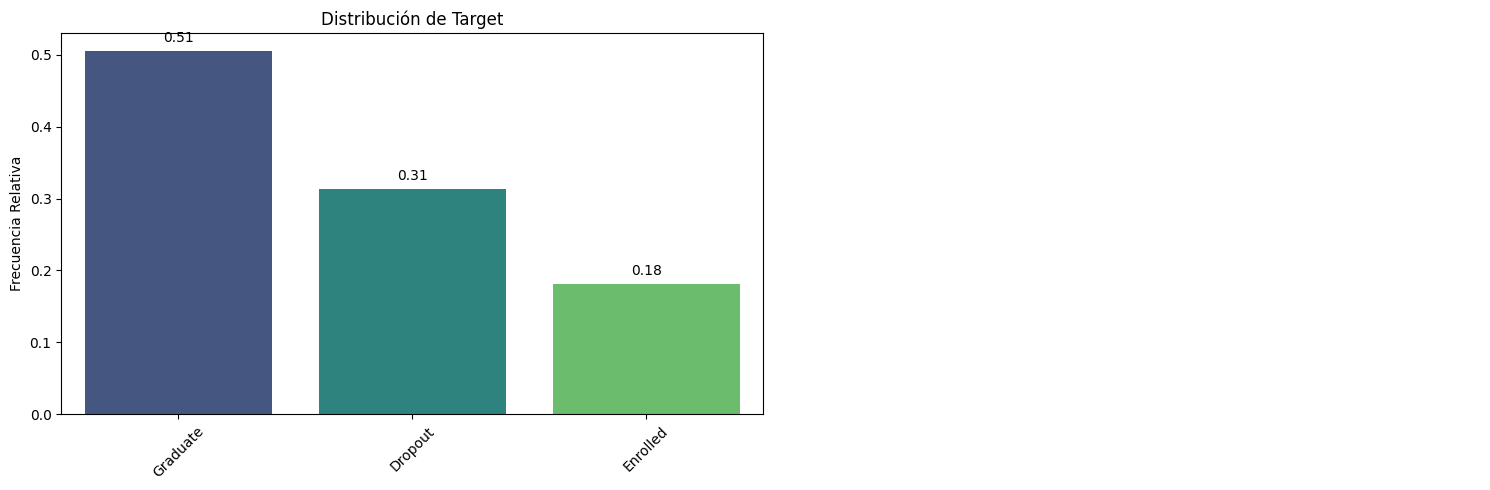

In [63]:
bt.pinta_distribucion_categoricas(train_set, [target], relativa=True, mostrar_valores=True)

Se puede realizar dos tipos de estrategias:
- **Oversampling** --> Genera datos sintéticos para las clases minoritarias.
- **Undersampling** --> Reduce las muestras de las clases mayoritarias.

Para nuestro entrenamiento, vamos a probar las dos posibilidades ya que no se sabe con exactitud cuál sería la mejor estrategia.

In [27]:
# Creo Pipelines con las dos estrategias
lgb = LGBMClassifier(random_state=42, verbose=-1)
pipe_over = ImbPipeline([
    ('preprocesado', preprocessing_all),
    ('smote', SMOTE(random_state=42)),
    ('model', lgb)
])

pipe_under = ImbPipeline([
    ('preprocesado', preprocessing_all),
    ('under', RandomUnderSampler(random_state=42)),
    ('model', lgb)
])

In [29]:
params_lgb = {
    'model__num_leaves': [15,31,63],
    'model__max_depth': [-1,10,20],
    'model__learning_rate': [0.1,0.01,0.05],
    'model__n_estimators': [100,200,400],
    'model__class_weight': [None, 'balanced']
}

names_imb = ['SMOTE', 'Under']
imb_pipe = [pipe_over, pipe_under]
grid_score = {}
for name,imb in zip(names_imb, imb_pipe):
    print(f'\nOptimizando con {name}:')
    grid_lgb = GridSearchCV(imb, param_grid=params_lgb, cv=10, scoring='balanced_accuracy', n_jobs=1)
    grid_lgb.fit(X_train[features_all], y_train)
    grid_score[name] = grid_lgb.best_score_
    print(f' - Mejores parámetros: {grid_lgb.best_params_}')
    print(f' - Score: {grid_lgb.best_score_:.4f}')



Optimizando con SMOTE:
 - Mejores parámetros: {'model__class_weight': None, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__num_leaves': 15}
 - Score: 0.7207

Optimizando con Under:
 - Mejores parámetros: {'model__class_weight': None, 'model__learning_rate': 0.05, 'model__max_depth': 20, 'model__n_estimators': 100, 'model__num_leaves': 31}
 - Score: 0.7266


No conseguimos unos resultados muy óptimos. Probaremos sin la librería Imbalanced-learn optimizando hiperparámetros

In [30]:
pipe_opt = Pipeline([
    ('preprocesado', preprocessing_all),
    ('model', lgb)
])

grid = GridSearchCV(pipe_opt, param_grid=params_lgb, cv=10, scoring='balanced_accuracy', n_jobs=1)
grid.fit(X_train[features_all], y_train)
grid_score['wout_imb'] = grid.best_score_
print(f' - Mejores parámetros: {grid.best_params_}')
print(f' - Score: {grid.best_score_:.4f}')

 - Mejores parámetros: {'model__class_weight': 'balanced', 'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__n_estimators': 100, 'model__num_leaves': 31}
 - Score: 0.7313


In [31]:
# Creo un DF con los resultados para poder guardarlo en mi equipo
rows = []
for imb, score in grid_score.items():
    rows.append({'Tecnica': imb, 'Score': score})
df_imb = pd.DataFrame(rows)
df_imb

,Tecnica,Score
0,SMOTE,0.720708
1,Under,0.726611
2,wout_imb,0.731332


Viendo los resultados, el mejor modelo es el entrenado con todas las features, con el modelo LGBClassifier y sin la librería imbalanced.

In [ ]:
#Guardo modelo con LGB sin imbalanced y con todas las features
with open('modelo_wouimb.pkl', 'wb') as archivo:
    pickle.dump(grid, archivo)

# Guardo modelo con UnderSampler y con LGB con todas las features
with open('modelo_under.pkl', 'wb') as archivo:
    pickle.dump(grid_lgb, archivo)

## Evaluación contra test
### Modelo **LightGBM**, **Imbalanced-learn (UnderSampler)** y **features_all**

In [42]:
print(classification_report(y_test, grid_lgb.predict(X_test)))

              precision    recall  f1-score   support

     Dropout       0.82      0.73      0.78       147
    Enrolled       0.48      0.67      0.56        83
    Graduate       0.84      0.77      0.80       213

    accuracy                           0.74       443
   macro avg       0.71      0.73      0.71       443
weighted avg       0.77      0.74      0.75       443



Teniendo en cuenta que lo que más me interesa son las clases `Dropout` y `Graduate`:
- Para la clase **`Dropout`**:
    - **Precisión (82%)** -> El model identifica correctamente la mayoría de los casos clasificados con esta clase.
    - **Recall (73%)** -> El modelo pierde alrededor del 27% de los estudiantes que realmente abandonan.
    - **F1-score (78%)** -> Indica un buen balance entre las dos métricas anteriores.
- Para la clase **`Graduate`**:
    - **Precisión (84%)** -> EL modelo clasifica casi a la perfección la mayoría de los estudiantes que se gradúan.
    - **Recall (77%)** -> EL modelo identifica la mayoría de los graduados.
    - **F1-score (80%)** -> Refleja la solidez de ambas métricas.
*Conclusión*:
- Realmente quiero identificar mejor la clase `Dropout` por lo que intenrare subir la métrica de **Recall** ya que identificar más casos de abandono podría ser crucial para acciones preventivas.

#### Reajuste de hiperparámetros y estratificación por el Target

In [60]:
# Creo set de entrenamiento, validacion y test estratificando por el target
train_val_set_str, test_set_str = train_test_split(df_map, test_size=0.1, stratify=df_map[target], random_state=42)
train_set_str, val_set_str = train_test_split(train_val_set_str, test_size=0.1111, stratify=train_val_set_str[target], random_state=42)

mapping = {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}

y_train_num_str = train_set_str[target].replace(mapping)
y_val_num_str = val_set_str[target].replace(mapping)
y_test_num_str = test_set_str[target].replace(mapping)

In [61]:
### DEMASIADO TIEMPO ENTRENANDO +742MIN (INTERRUMPO)
params_lgb_under_opt = {
    'model__num_leaves': [15,31,63,100,200], # Aumento valores
    'model__max_depth': [-1,10,15,20,25], # Incluyo valores intermedios
    'model__learning_rate': [0.001,0.005,0.1,0.01,0.05], # Incluyo valores más pequeños
    'model__n_estimators': [100,200,400],
    'model__subsample': [0.6,0.8,1.0], # Reduce el overfitting
    'model__colsample_bytree': [0.6,0.8,1.0], # Selecciona subconjuntos de características en cada árbol
    'model__child_weight': [1,5,10], # Ajusta la regularización
    'model__class_weight': [None, 'balanced']
}

grid_lgb_under_opt = GridSearchCV(pipe_under, param_grid=params_lgb_under_opt, cv=10, scoring='balanced_accuracy', n_jobs=1)
grid_lgb_under_opt.fit(train_set_str[features_all], train_set_str[target])
print(f' - Mejores parámetros: {grid_lgb_under_opt.best_params_}')
print(f' - Score: {grid_lgb_under_opt.best_score_:.4f}')

KeyboardInterrupt: 

### Modelo **LightGBM** y **features_all**

In [35]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

     Dropout       0.82      0.76      0.79       147
    Enrolled       0.52      0.59      0.55        83
    Graduate       0.85      0.84      0.84       213

    accuracy                           0.77       443
   macro avg       0.73      0.73      0.73       443
weighted avg       0.78      0.77      0.77       443



*Análisis*:

Para la clase **`Dropout`**:
- **Precision: (82%)** -> (bueno). Esto indica que el modelo identifica correctamente la mayoría de los casos etiquetados como Dropout.
- **Recall: (76%)** -> (ligeramente mejor que antes). Esto muestra que el modelo está capturando más de los casos reales de Dropout.
- **F1-score: (79%)** -> Un equilibrio adecuado entre precisión y recall.  

Para la clase **`Graduate`**:
- **Precision: (85%)** -> Excelente precisión, similar a la obtenida antes.
- **Recall: (84%)** -> (mejor) Esto asegura que el modelo identifica correctamente más estudiantes que realmente se gradúan.
- **F1-score: (84%)** -> Sólido y consistente, lo que es importante dado que esta es una clase prioritaria.

*Mejoras*:
 - Hay mejoras claras en las clases prioritarias (`Dropout` y `Graduate`) tanto en recall como en f1-score.
- La precisión general de `Dropout` y `Graduate` es similar o superior sin aplicar técnicas de desbalanceo.

### Modelo **LightGBM**, **Imbalanced-learn (SMOTE)** y **features_all**

In [31]:
params_over = {
    'model__num_leaves': [15,31,63],
    'model__max_depth': [-1,10,20],
    'model__learning_rate': [0.1,0.01,0.05],
    'model__n_estimators': [100,200,400],
    'model__class_weight': [None, 'balanced']
}
print('Optimizando con SMOTE estratificando')
grid_over_str = GridSearchCV(pipe_over, param_grid=params_over, cv=5, scoring='balanced_accuracy')
grid_over_str.fit(train_set_str[features_all], train_set_str[target])
print(f' - Mejores parámetros: {grid_over_str.best_params_}')
print(f' - Score: {grid_over_str.best_score_:.4f}')


Optimizando con SMOTE estratificando
 - Mejores parámetros: {'model__class_weight': None, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__num_leaves': 63}
 - Score: 0.7083


In [32]:
print(classification_report(test_set_str[target], grid_over_str.predict(test_set_str[features_all])))

              precision    recall  f1-score   support

     Dropout       0.81      0.76      0.78       142
    Enrolled       0.52      0.40      0.45        80
    Graduate       0.83      0.92      0.87       221

    accuracy                           0.78       443
   macro avg       0.72      0.69      0.70       443
weighted avg       0.76      0.78      0.77       443



*Análisis*:

Para la clase **`Dropout`**:
- **Precision: (81%)** -> Muy similar a los resultados anteriores, lo que indica que el modelo identifica correctamente los casos etiquetados como Dropout.
- **Recall: (76%)** -> Esto es consistente con los resultados previos, mostrando que el modelo mantiene su capacidad de capturar casos de Dropout.
- **F1-score: (78%)** -> Indica un balance adecuado entre precisión y recall para esta clase prioritaria.

Para la clase **`Graduate`**:
- **Precision: (83%)** -> Muy alta, consistente con los resultados previos.
- **Recall: (92%)** -> Una mejora significativa, lo que sugiere que SMOTE ha ayudado a capturar correctamente más casos de Graduate.
- **F1-score: (87%)** -> El puntaje más alto entre las clases, lo cual es excelente dado que es otra clase prioritaria.

*Comparación con las anteriores*:
- El recall de `Graduate` mejoró significativamente con SMOTE (de 0.84 a 0.92).
- Sin embargo, el desempeño de `Dropout` y `Graduate` en general es comparable entre los dos enfoques.

In [ ]:
with open('modelo_smote.pkl', 'wb') as archivo:
    pickle.dump(grid_over_str, archivo)

### Selección de la mejor métrica con **SMOTE**

In [36]:
## Entreno con SMOTE un cv con la seleccion de features y varios modelos
cv_smote = {}
names_selector = ['features_visual', 'features_test', 'features_rfe', 'features_hard', 'features_all'] 
pipes_preprocessing = [preprocessing_visual, preprocessing_test, preprocessing_rfe, preprocessing_hard, preprocessing_all]
features_selection = [features_visual, features_test, features_rfe, features_hard, features_all] # Añadimos una selección con TODAS las features
names_models = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
models = [RandomForestClassifier(random_state=42), XGBClassifier(), LGBMClassifier(random_state=42, verbose=-1), CatBoostClassifier(random_state=42, verbose=0)]
# Entreno todos los modelos con todas las selecciones de features
for name_features, pipe_prep, features in zip(names_selector, pipes_preprocessing, features_selection):
    cv_smote[name_features] = []  # Para almacenar resultados de cada modelo con esta selección de features
    print(f"\nEntrenando con selección de features: {name_features}, con SMOTE")
    
    for model, name_model in zip(models, names_models):
        model_pipe = ImbPipeline([
            ('preprocesado', pipe_prep),
            ('smote', SMOTE(random_state=42)),
            ('model', model)
        ])
        
        cv_score = np.mean(cross_val_score(model_pipe, X_train[features], y_train_num, cv=5, scoring='balanced_accuracy'))
        print(f' - {name_model} tiene un score de {cv_score}')
        
        cv_smote[name_features].append((name_model, cv_score))


Entrenando con selección de features: features_visual, con SMOTE
 - RandomForest tiene un score de 0.6898493519077646
 - XGBoost tiene un score de 0.7138320514602049
 - LightGBM tiene un score de 0.7172907404496514
 - CatBoost tiene un score de 0.7084278589827567

Entrenando con selección de features: features_test, con SMOTE
 - RandomForest tiene un score de 0.5925812711231758
 - XGBoost tiene un score de 0.6006060885633189
 - LightGBM tiene un score de 0.6017133888010695
 - CatBoost tiene un score de 0.6054831191008316

Entrenando con selección de features: features_rfe, con SMOTE
 - RandomForest tiene un score de 0.6380929103271388
 - XGBoost tiene un score de 0.6328860162722573
 - LightGBM tiene un score de 0.632411873209042
 - CatBoost tiene un score de 0.6406331637276992

Entrenando con selección de features: features_hard, con SMOTE
 - RandomForest tiene un score de 0.6797881846212246
 - XGBoost tiene un score de 0.6806608027274716
 - LightGBM tiene un score de 0.68008435846094

In [37]:
rows = []
for features_name, model_scores in cv_smote.items():
    for model_name,score in model_scores:
        rows.append({'Features': features_name, 'Model': model_name, 'Score': score})
df_baseline_smote = pd.DataFrame(rows)
df_baseline_smote

,Features,Model,Score
0,features_visual,RandomForest,0.689849
1,features_visual,XGBoost,0.713832
2,features_visual,LightGBM,0.717291
3,features_visual,CatBoost,0.708428
4,features_test,RandomForest,0.592581
5,features_test,XGBoost,0.600606
6,features_test,LightGBM,0.601713
7,features_test,CatBoost,0.605483
8,features_rfe,RandomForest,0.638093
9,features_rfe,XGBoost,0.632886


In [38]:
ruta = './data/results/baseline_smote.csv'
df_baseline_smote.to_csv(ruta, index=False)

Mayor puntuacion:
- Features_visual --> XGBoost, LightGBM
- Features_all --> CatBoost

### **XGBoost** con **features_visual**

In [ ]:
pipe_smote_xgb = ImbPipeline([
    ('preprocesado', preprocessing_visual),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier())
])


In [50]:
params_smote_xgb = {
    'model__learning_rate': [0.01,0.1,0.2],
    'model__n_estimators': [100,300,500],
    'model__max_depth': [3,6,10],
    'model__min_child_weight': [1,3,5],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0,0.1,0.3] 
}
print('Optimizando con SMOTE estratificando, features_visual y XGBoost')
grid_smote_xgb = GridSearchCV(pipe_smote_xgb, param_grid=params_smote_xgb, cv=5, scoring='balanced_accuracy', n_jobs=1)
grid_smote_xgb.fit(train_set_str[features_visual], y_train_num_str)
print(f' - Mejores parámetros: {grid_smote_xgb.best_params_}')
print(f' - Score: {grid_smote_xgb.best_score_:.4f}')

Optimizando con SMOTE estratificando, features_visual y XGBoost
 - Mejores parámetros: {'model__colsample_bytree': 0.6, 'model__gamma': 0.3, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__min_child_weight': 1, 'model__n_estimators': 300}
 - Score: 0.7124


In [51]:
with open('modelo_smote_xgb.pkl', 'wb') as archivo:
    pickle.dump(grid_smote_xgb, archivo)

In [53]:
print(classification_report(y_test_num_str, grid_smote_xgb.predict(test_set_str[features_visual])))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       221
           1       0.83      0.74      0.78       142
           2       0.47      0.47      0.47        80

    accuracy                           0.77       443
   macro avg       0.71      0.70      0.71       443
weighted avg       0.77      0.77      0.77       443



*Análisis*:

Para la Cclase **`Graduate`** (0):
- **Precision: (85%)** -> El modelo identifica correctamente la mayoría de los casos predichos como Graduate.
- **Recall: (90%)** -> El modelo captura casi todos los casos reales de Graduate, lo cual es excelente.
- **F1-score: (87%)** -> Refleja un desempeño muy sólido para esta clase prioritaria.

Para la clase **`Dropout`** (1):
- **Precision: (83%)** -> Indica una buena capacidad para predecir correctamente los casos de Dropout.
- **Recall: (74%)** -> Una ligera mejora respecto a iteraciones anteriores, pero todavía hay margen para capturar más casos reales de Dropout.
- **F1-score: (78%)** -> Muestra un buen balance entre precisión y recall para esta clase prioritaria.

*Comparación*:
- Ambas clases (`Graduate` y `Dropout`) mantienen un buen desempeño (F1-score ≥ 0.78), lo que es positivo dado su importancia prioritaria.
- El uso de **SMOTE** no parece haber afectado significativamente su desempeño en comparación con enfoques sin técnicas de desbalanceo.

### Modelo combinando **SMOTE** y **UnderSampler**

In [ ]:
## Combinacion de smote con undersampling

pipe_smoteen_xgb = ImbPipeline([
    ('preprocesado', preprocessing_all),
    ('smoteen', SMOTEENN(random_state=42)),
    ('model', XGBClassifier(random_state=42))
])

param_smoteen_xgb = {
    'model__learning_rate': [0.01,0.1,0.2],
    'model__n_estimators': [100,300,500],
    'model__max_depth': [3,6,10],
    'model__min_child_weight': [1,3,5],
    'model__subsample': [0.6,0.8,1.0],
    'model__colsample_bytree': [0.6,0.8,1.0],
    'model__gamma': [0,0.1,0.3]
}

In [70]:
grid_smoteen_xgb = GridSearchCV(pipe_smoteen_xgb, param_grid=param_smoteen_xgb, cv=5, scoring='f1_macro', n_jobs=1, verbose=1)
grid_smoteen_xgb.fit(train_set_str[features_all], y_train_num_str)
print(f' - Mejores parámetros: {grid_smoteen_xgb.best_params_}')
print(f' - Score: {grid_smoteen_xgb.best_score_:.4f}')

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
 - Mejores parámetros: {'model__colsample_bytree': 1.0, 'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 3, 'model__n_estimators': 100, 'model__subsample': 0.6}
 - Score: 0.6864


In [71]:
with open('modelo_smoteenn_xgb.pkl', 'wb') as archivo:
    pickle.dump(grid_smoteen_xgb, archivo)

In [73]:
print(classification_report(y_test_num_str, grid_smoteen_xgb.predict(test_set_str[features_all])))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       221
           1       0.87      0.67      0.76       142
           2       0.40      0.79      0.53        80

    accuracy                           0.72       443
   macro avg       0.72      0.73      0.70       443
weighted avg       0.80      0.72      0.74       443



### Eliminación de la categoróa **'Enrolled'**

Como, en realidad, la clase 'Enrolled' realmente no interesan demasiado en este proyecto, y, al tener una distribución tan baja, hace que mis predicciones en las dos clases restantes se vean afectadas. Por lo cual, reflexionando he tomado la decisión de eliminar los datos que corresponden a esta clase en el entrenamiento.

Sin embargo, estos datos no van a ser deshechados, es decir, como esos estudiantes están matriculados pero aún ni han abandonado ni se han graduado, ¿qué mejor que predecir lo que van a hacer esos estudiantes?

In [ ]:
df_target = df_map.loc[(df_map[target] == 'Dropout') | (df_map[target] == 'Graduate')]

In [77]:
# Generamos sets
train_val_set_opt, test_set_opt = train_test_split(df_target, test_size=0.1, stratify=df_target[target], random_state=42)
train_set_opt, val_set_opt = train_test_split(train_val_set_opt, test_size=0.1111, stratify=train_val_set_opt[target], random_state=42)

In [ ]:
# Veo la distribución de las dos clases
train_set_opt[target].value_counts(True)

Target
Graduate    0.608471
Dropout     0.391529
Name: proportion, dtype: float64

In [80]:
# Transformo las clases a numérica
mapping = {'Graduate': 0, 'Dropout': 1}

y_train_num_opt = train_set_opt[target].replace(mapping)
y_val_num_opt = val_set_opt[target].replace(mapping)
y_test_num_opt = test_set_opt[target].replace(mapping)

Vuelvo a realizar el **Baseline** con estos datos

In [84]:
# Listas de nombres y objetos
cv_opt = {}
names_selector = ['features_visual', 'features_test', 'features_rfe', 'features_hard', 'features_all'] 
pipes_preprocessing = [preprocessing_visual, preprocessing_test, preprocessing_rfe, preprocessing_hard, preprocessing_all]
features_selection = [features_visual, features_test, features_rfe, features_hard, features_all] # Añadimos una selección con TODAS las features
names_models = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
models = [RandomForestClassifier(random_state=42), XGBClassifier(), LGBMClassifier(random_state=42, verbose=-1), CatBoostClassifier(random_state=42, verbose=0)]

# Entreno todos los modelos con todas las selecciones de features
for name_features, pipe_prep, features in zip(names_selector, pipes_preprocessing, features_selection):
    print(f"\nEntrenando con selección de features: {name_features}")
    
    cv_opt[name_features] = []
    for model, name_model in zip(models, names_models):
        model_pipe = Pipeline([
            ('preprocesado', pipe_prep),
            ('model', model)
        ])
        cv_score = np.mean(cross_val_score(model_pipe, train_set_opt[features], y_train_num_opt, cv=5, scoring='balanced_accuracy', verbose=1))
        cv_opt[name_features].append((name_model, cv_score))
        print(f' - {name_model} tiene un score de {cv_score}')


Entrenando con selección de features: features_visual
 - RandomForest tiene un score de 0.8863960828186366
 - XGBoost tiene un score de 0.892675380735173
 - LightGBM tiene un score de 0.8929274679423713
 - CatBoost tiene un score de 0.8945334509908032

Entrenando con selección de features: features_test
 - RandomForest tiene un score de 0.8343476451156014
 - XGBoost tiene un score de 0.8366735995045996
 - LightGBM tiene un score de 0.8404746340824081
 - CatBoost tiene un score de 0.8532943257504744

Entrenando con selección de features: features_rfe
 - RandomForest tiene un score de 0.8495873938814427
 - XGBoost tiene un score de 0.8402474438480168
 - LightGBM tiene un score de 0.8524765874292978
 - CatBoost tiene un score de 0.8593684246298843

Entrenando con selección de features: features_hard
 - RandomForest tiene un score de 0.8826504599387549
 - XGBoost tiene un score de 0.8804856332248955
 - LightGBM tiene un score de 0.8841344423469399
 - CatBoost tiene un score de 0.884689616

De nuevo, realizo la búsqueda del mejor componente para realizar una reducción de la dimensionalidad con **PCA**

In [85]:
X_train_processed_opt = preprocessing_all.fit_transform(train_set_opt[features_all])

In [86]:
X_train_processed_opt

array([[ 0.39625715, -0.4416367 , -0.35393944, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.16826294, -0.60102783, -0.35393944, ...,  1.        ,
         0.        ,  0.        ],
       [-0.59903141, -0.76466989, -0.35393944, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.16826294, -0.76466989, -0.35393944, ...,  1.        ,
         1.        ,  0.        ],
       [-0.59903141,  0.70329458,  3.91851457, ...,  1.        ,
         0.        ,  0.        ],
       [-0.59903141,  0.57132791, -0.35393944, ...,  1.        ,
         0.        ,  0.        ]])

In [87]:
pca = PCA()
X_train_ncomp_pca = pca.fit(X_train_processed_opt)

varizanza_acumulada = pca.explained_variance_ratio_.cumsum()
varizanza_acumulada

array([0.56704233, 0.78169026, 0.83563755, 0.86629162, 0.88819515,
       0.9014537 , 0.91277887, 0.92225011, 0.9312494 , 0.9393483 ,
       0.94553653, 0.95098431, 0.95607873, 0.95988455, 0.96314177,
       0.96598917, 0.96811921, 0.969882  , 0.97150868, 0.97303812,
       0.97441975, 0.97572547, 0.97692803, 0.97808878, 0.97912041,
       0.98011546, 0.98107961, 0.98200191, 0.98289221, 0.98368183,
       0.98443139, 0.98514032, 0.9858251 , 0.98649808, 0.98714342,
       0.98775886, 0.98836619, 0.98894888, 0.98952411, 0.990072  ,
       0.99060511, 0.99112222, 0.99163632, 0.99212035, 0.99259311,
       0.9930599 , 0.99351157, 0.99393683, 0.99434441, 0.99471355,
       0.99507108, 0.99541367, 0.99574194, 0.99606633, 0.99633829,
       0.99660067, 0.99684848, 0.99709053, 0.9973196 , 0.99754261,
       0.9977462 , 0.9979299 , 0.99810777, 0.99827635, 0.99842935,
       0.99856944, 0.99869824, 0.99880482, 0.99889462, 0.99897458,
       0.99905427, 0.99912856, 0.99919877, 0.99926423, 0.99932

In [99]:
umbral = len(varizanza_acumulada[varizanza_acumulada >= 0.99]) 
n_componentes_99 = X_train_processed_opt.shape[1] - umbral + 1
                                                            
print(f'Componentes que exceden el 99%: {umbral}')
print(f'El numero de componentes necesarias para alcanzar el {round(varizanza_acumulada[31],2)} es {n_componentes_99}')

Componentes que exceden el 99%: 113
El numero de componentes necesarias para alcanzar el 0.99 es 40


In [100]:
n_componentes_pca = 40

In [101]:
names_models = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
models = [RandomForestClassifier(random_state=42), XGBClassifier(), LGBMClassifier(random_state=42, verbose=-1), CatBoostClassifier(random_state=42, verbose=0)]

print('Entrenando con selección de PCA:')
cv_opt['pca'] = []  

for model, name_model in zip(models, names_models):
    model_pipe = Pipeline([
        ('pca', PCA(n_components=n_componentes_pca)),
        ('model', model)
    ])
    
    cv_score = np.mean(cross_val_score(model_pipe, X_train_processed_opt, y_train_num_opt, cv=5, scoring='balanced_accuracy'))
    print(f' - {name_model} tiene un score de {cv_score}')
    
    cv_opt['pca'].append((name_model, cv_score))

Entrenando con selección de PCA:
 - RandomForest tiene un score de 0.8693257887889224
 - XGBoost tiene un score de 0.8752637356358697
 - LightGBM tiene un score de 0.877524402011302
 - CatBoost tiene un score de 0.8794810651884033


In [102]:
# Inicializo variables para almacenar los mejores resultados
best_score = -np.inf  # Inicializamos con un valor bajo
best_model = None
best_features = None

for features_name, model_scores in cv_opt.items():
    for model_name, score in model_scores:
        if score > best_score:
            best_score = score
            best_model = model_name
            best_features = features_name

print(f"El mejor modelo es {best_model} con un score de {best_score:.4f}, usando la selección de features: {best_features}")


El mejor modelo es XGBoost con un score de 0.8967, usando la selección de features: features_all


In [103]:
# Creo un DF con los resultados para poder guardarlo en mi equipo
rows = []
for features_name, model_scores in cv_opt.items():
    for model_name,score in model_scores:
        rows.append({'Features': features_name, 'Model': model_name, 'Score': score})
df_baseline_opt = pd.DataFrame(rows)
df_baseline_opt

,Features,Model,Score
0,features_visual,RandomForest,0.886396
1,features_visual,XGBoost,0.892675
2,features_visual,LightGBM,0.892927
3,features_visual,CatBoost,0.894533
4,features_test,RandomForest,0.834348
5,features_test,XGBoost,0.836674
6,features_test,LightGBM,0.840475
7,features_test,CatBoost,0.853294
8,features_rfe,RandomForest,0.849587
9,features_rfe,XGBoost,0.840247


In [105]:
ruta = './data/results/baseline_opt.csv'
df_baseline_opt.to_csv(ruta, index=False)

#### Modelo **XGBoost** con **SMOTE** y **features_all**
Como quiero que rinda mejor en la clase minoritaria, en este caso, **Dropout**, realizo la técnica de **SMOTE**

In [110]:
pipe_xgb_smote_opt = ImbPipeline([
    ('preprocesado', preprocessing_all),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss')) # 'logloss' -> Penaliza más fuertemente las predicciones incorrectas cuando el modelo está demasiado confiado (es decir, cuando asigna una probabilidad alta a la clase equivocada).
])

In [112]:
param_xgb_smote_opt = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.3],
    'model__n_estimators': [50, 100, 200],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__scale_pos_weight': [1.5, 2.0]  # Ajusta según el desbalanceo
}

# Scoring de 'f1_macro' ya que quiero evaluar el rendimiento en amblas clases de manera justa, sin dejar que el desbalance afecte demasiado en el metrica
grid_xgb_smote_opt = GridSearchCV(pipe_xgb_smote_opt, param_grid=param_xgb_smote_opt, cv=5, scoring='f1_macro')

grid_xgb_smote_opt.fit(train_set_opt[features_all], y_train_num_opt)
print(f' - Mejores parámetros: {grid_xgb_smote_opt.best_params_}')
print(f' - Score: {grid_xgb_smote_opt.best_score_:.4f}')

 - Mejores parámetros: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__scale_pos_weight': 2.0, 'model__subsample': 0.8}
 - Score: 0.9054


In [116]:
print(classification_report(y_test_num_opt, grid_xgb_smote_opt.predict(test_set_opt[features_all])))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       221
           1       0.91      0.89      0.90       142

    accuracy                           0.92       363
   macro avg       0.92      0.92      0.92       363
weighted avg       0.92      0.92      0.92       363



Para la clase 0 (**`Graduate`**):
- **Precision (93%)** -> El modelo predijo correctamente que un estudiante se graduará en el 93% de los casos en los que hizo esa predicción.
- **Recall (95%)** -> El modelo identificó correctamente el 95% de los estudiantes que realmente se graduaron.
- **F1-Score (94%)** -> Combina precisión y recall, lo que indica un equilibrio muy bueno para esta clase.

Para la clase 1 (**`Dropout`**):
- **Precision (91%)** -> El modelo predijo correctamente que un estudiante abandonará en el 91% de los casos en los que hizo esa predicción.
- **Recall (89%)** -> El modelo identificó correctamente el 89% de los estudiantes que realmente abandonaron.
- **F1-Score (90%)** -> Buen equilibrio entre precisión y recall para esta clase, aunque ligeramente menor que para los graduados.

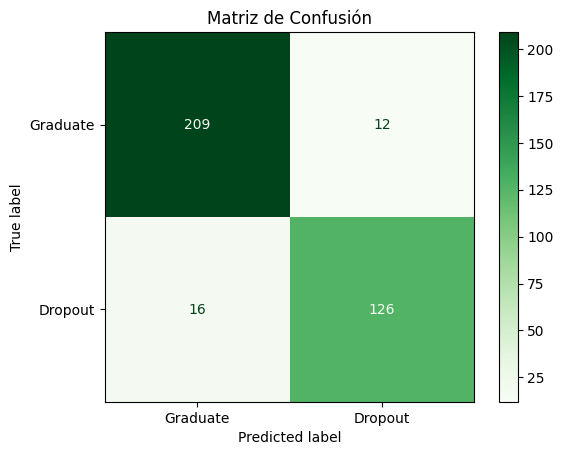

In [ ]:
cm = confusion_matrix(y_test_num_opt, grid_xgb_smote_opt.predict(test_set_opt[features_all]))
confusion = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Graduate', 'Dropout'])
confusion.plot(cmap=plt.cm.Greens)
plt.title("Matriz de Confusión")
plt.show()

En esta matriz podemos ver mejor cómo predice el modelo.
- El modelo predice 142 estudiantes como que **abandonan**. Sin embargo, de esos 142, 126 son clasificados correctamente y 16 son graduados clasificados incorrectamente como abandonos
- Predice que 221 son estudiantes que se **gradúa**, pero 209 son correctos y 12 son incorrectos.

En general, es un buen modelo a la hora de predecir estudiantes que abandonan o se gradúan.

In [ ]:
with open('modelo_best.pkl', 'wb') as archivo:
    pickle.dump(grid_xgb_smote_opt, archivo)

In [118]:
grid_xgb_smote_opt.best_estimator_

Pipeline(steps=[('preprocesado',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Impute_numeric',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function log_transform at 0x000002CC24B1B1A0>)),
                                                                  ('SScaler',
                                                                   StandardScaler())]),
                                                  ['Application order',
                                                   'Age at enrollment',
                                                   'Curricular units 1st sem '
                                                   '(credited)',
                                                   'Curricular uni...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
# Cargo el mejor modelo
with open('modelo_best.pkl', 'rb') as file:
    load_model = pickle.load(file)

## Preidcción sobre datos nuevos

Genero los datos que hemos guardado para predecir si un estudiante que esrá matriculado

In [19]:
new_data = df_map.loc[df_map[target] == 'Enrolled']
new_data.drop(columns=['Target'], inplace=True)
new_data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
16,Single,3rd phase—general contingent,1,Social Service,1,Secondary education,Portuguese,General commerce course,Basic Education 2nd Cycle (6th/7th/8th Year) o...,"Personal Services, Security and Safety Workers...",...,0,0,6,14,2,11.000,0,10.8,1.4,1.74
19,Single,1st phase—general contingent,1,Basic Education,1,Secondary education,Portuguese,General commerce course,Basic Education 3rd Cycle (9th/10th/11th Year)...,"Skilled Workers in Industry, Construction, and...",...,0,0,7,8,6,13.500,0,16.2,0.3,-0.92
21,Single,3rd phase—general contingent,4,Oral Hygiene,1,Secondary education,Portuguese,Secondary Education—12th Year of Schooling or ...,Basic Education 2nd Cycle (6th/7th/8th Year) o...,Administrative staff,...,0,0,8,9,8,11.425,0,12.7,3.7,-1.70
25,Single,1st phase—general contingent,1,Social Service,1,Secondary education,Portuguese,General commerce course,Basic Education 2nd Cycle (6th/7th/8th Year) o...,Unskilled Workers,...,0,0,6,12,4,11.000,0,7.6,2.6,0.32
27,Single,1st phase—general contingent,1,Veterinary Nursing,1,Secondary education,Portuguese,General commerce course,Basic Education 3rd Cycle (9th/10th/11th Year)...,Intermediate Level Technicians and Professions,...,2,0,5,7,4,13.000,0,9.4,-0.8,-3.12


In [ ]:
# Genero las predicciones
best_model = best_model.best_estimator_
predicciones = best_model.predict(new_data)
predicciones

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,

In [ ]:
# Probabilidades de que sea de una clase u otra
probabilidades = best_model.predict_proba(new_data)
probabilidades

array([[0.00258076, 0.99741924],
       [0.9212873 , 0.07871272],
       [0.9747293 , 0.02527072],
       ...,
       [0.00294089, 0.9970591 ],
       [0.7508519 , 0.24914806],
       [0.00145864, 0.99854136]], dtype=float32)

Añado la predicción al DF

In [22]:
new_data['Predicciones'] = predicciones

In [24]:
mapeo = {0:'Graduate', 1:'Dropout'}
new_data['Predicciones'] = new_data['Predicciones'].map(mapeo)

In [25]:
new_data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Predicciones
16,Single,3rd phase—general contingent,1,Social Service,1,Secondary education,Portuguese,General commerce course,Basic Education 2nd Cycle (6th/7th/8th Year) o...,"Personal Services, Security and Safety Workers...",...,0,6,14,2,11.000,0,10.8,1.4,1.74,Dropout
19,Single,1st phase—general contingent,1,Basic Education,1,Secondary education,Portuguese,General commerce course,Basic Education 3rd Cycle (9th/10th/11th Year)...,"Skilled Workers in Industry, Construction, and...",...,0,7,8,6,13.500,0,16.2,0.3,-0.92,Graduate
21,Single,3rd phase—general contingent,4,Oral Hygiene,1,Secondary education,Portuguese,Secondary Education—12th Year of Schooling or ...,Basic Education 2nd Cycle (6th/7th/8th Year) o...,Administrative staff,...,0,8,9,8,11.425,0,12.7,3.7,-1.70,Graduate
25,Single,1st phase—general contingent,1,Social Service,1,Secondary education,Portuguese,General commerce course,Basic Education 2nd Cycle (6th/7th/8th Year) o...,Unskilled Workers,...,0,6,12,4,11.000,0,7.6,2.6,0.32,Dropout
27,Single,1st phase—general contingent,1,Veterinary Nursing,1,Secondary education,Portuguese,General commerce course,Basic Education 3rd Cycle (9th/10th/11th Year)...,Intermediate Level Technicians and Professions,...,0,5,7,4,13.000,0,9.4,-0.8,-3.12,Graduate


In [26]:
# Veo la distribución de las clases
new_data['Predicciones'].value_counts(True)

Predicciones
Dropout     0.511335
Graduate    0.488665
Name: proportion, dtype: float64

Ambas clases tienen la distribución muy parecida por lo que está más o menos equilibrado